# Analyzing Tune Experiment Results

In this guide, we'll walk through some common workflows of what analysis you might want to perform after running your Tune experiment with `tuner.fit()`.

1. Loading Tune experiment results from a directory
2. Basic *experiment-level* analysis: get a quick overview of how trials performed
3. Basic *trial-level* analysis: access individual trial hyperparameter configs and last reported metrics
4. Plotting the entire history of reported metrics for a trial
5. Accessing saved checkpoints (assuming that you have enabled checkpointing) and loading into a model for test inference

```python
result_grid: ResultGrid = tuner.fit()
best_result: Result = result_grid.get_best_result()
```

The output of `tuner.fit()` is a [`ResultGrid`](result-grid-docstring), which is a collection of [`Result`](result-docstring) objects. See the linked documentation references for [`ResultGrid`](result-grid-docstring) and [`Result`](result-docstring) for more details on what attributes are available.

Let's start by performing a hyperparameter search with the MNIST PyTorch example. The training function is defined {doc}`here </tune/examples/includes/mnist_pytorch>`, and we pass it into a `Tuner` to start running the trials in parallel.

In [ ]:
from ray import tune, air
from ray.tune.examples.mnist_pytorch import train_mnist

exp_name = "tune_analyzing_results"
tuner = tune.Tuner(
    train_mnist,
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9, 0.99]),
        "should_checkpoint": True,
    },
    run_config=air.RunConfig(
        name=exp_name,
        stop={"training_iteration": 100},
        checkpoint_config=air.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=5,
        )
    ),
    tune_config=tune.TuneConfig(mode="max", metric="mean_accuracy", num_samples=3),
)
result_grid: ResultGrid = tuner.fit()

## Loading experiment results from an directory

Although we have the `result_grid` object in memory because we just ran the Tune experiment above, we might be performing this analysis after our initial training script has exited. To recover the `ResultGrid`, we can load it from the experiment directory, which should look something like `~/ray_results/{exp_name}`. If you don't specify a `name` in the `RunConfig`, the experiment name will be auto-generated and can be found in the logs of your experiment.

In [ ]:
from ray.tune import ResultGrid, ExperimentAnalysis

experiment_path = f"~/ray_results/{exp_name}"
result_grid = ResultGrid(ExperimentAnalysis(experiment_path))

## Experiment-level Analysis: Working with `ResultGrid`

The first thing we might want to check is if there were any erroring trials.

In [3]:
# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

No errors!


The output of `tuner.fit()` is a [`ResultGrid`](result-grid-docstring), which is a collection of [`Result`](result-docstring) objects, one for each Tune trial. We should have **9** results in this example, since we have 3 samples for each of the 3 grid search values.

Note that `ResultGrid` is an iterable, and we can access its length and index into it to access individual `Result` objects.

In [4]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 9


In [5]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(f"Trial #{i} finished successfully with a mean accuracy metric of:", result.metrics["mean_accuracy"])

Trial #0 finished successfully with a mean accuracy metric of: 0.94375
Trial #1 finished successfully with a mean accuracy metric of: 0.959375
Trial #2 finished successfully with a mean accuracy metric of: 0.89375
Trial #3 finished successfully with a mean accuracy metric of: 0.971875
Trial #4 finished successfully with a mean accuracy metric of: 0.96875
Trial #5 finished successfully with a mean accuracy metric of: 0.103125
Trial #6 finished successfully with a mean accuracy metric of: 0.95625
Trial #7 finished successfully with a mean accuracy metric of: 0.94375
Trial #8 finished successfully with a mean accuracy metric of: 0.940625


Above, we printed the last reported `mean_accuracy` metric for all trials by looping through the `result_grid`.
We can access the same metrics for all trials in a pandas DataFrame.

In [6]:
results_df = result_grid.get_dataframe()
results_df["mean_accuracy"]

0    0.943750
1    0.959375
2    0.893750
3    0.971875
4    0.968750
5    0.103125
6    0.956250
7    0.943750
8    0.940625
Name: mean_accuracy, dtype: float64

In [7]:
print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

Shortest training time: 13.788248062133787
Longest training time: 18.073718786239624


## Trial-level Analysis: Working with an individual `Result`

Let's take a look at the result that ended with the best `mean_accuracy` metric. By default, `get_best_result` will use the same metric and mode as defined in the `TuneConfig` above. However, it's also possible to specify a new metric/order in which results should be ranked.

In [11]:
# Get the result with the maximum test set `mean_accuracy`
best_result = result_grid.get_best_result(
    metric="mean_accuracy", mode="max"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result = result_grid.get_best_result(
    metric="mean_accuracy", mode="min"
)

In [12]:
best_result.config

{'lr': 0.035957171723216524, 'momentum': 0.8, 'should_checkpoint': True}

In [ ]:
best_result.log_dir

`PosixPath('~/ray_results/tune_analyzing_results/train_mnist_922d4_00005_5_lr=0.0030,momentum=0.9900_2022-10-04_14-50-35')`

The result `log_dir` gives the trial level directory that contains checkpoints (if you had checkpointing enabled) and logged metrics to load manually or inspect using tools like Tensorboard (see `result.json`, `progress.csv`).

In [ ]:
# Get the last Ray AIR Checkpoint associated with the best-performing trial
best_result.checkpoint

In [48]:
# Get the last reported set of metrics
best_result.metrics

{'mean_accuracy': 0.971875,
 'training_loss': None,
 'time_this_iter_s': 0.06795501708984375,
 'should_checkpoint': True,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'training_iteration': 100,
 'trial_id': 'd27fc_00003',
 'experiment_id': '530bdf3c5c1840e89f124c3662d0cccb',
 'date': '2022-10-04_16-40-06',
 'time_total_s': 18.073718786239624,
 'config': {'lr': 0.035957171723216524,
  'momentum': 0.8,
  'should_checkpoint': True},
 'time_since_restore': 18.073718786239624,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 100,
 'warmup_time': 0.0023250579833984375,
 'experiment_tag': '3_lr=0.0360,momentum=0.8000'}

Access the entire history of reported metrics from a `Result` as a pandas DataFrame:

In [20]:
result_df = best_result.metrics_dataframe
result_df[["training_iteration", "mean_accuracy", "time_total_s"]]

,training_iteration,mean_accuracy,time_total_s
0,1,0.696875,0.102304
1,2,0.821875,0.413158
2,3,0.793750,0.575325
3,4,0.834375,0.821425
4,5,0.856250,1.031370
...,...,...,...
95,96,0.940625,17.744601
96,97,0.975000,17.859755
97,98,0.962500,17.931956
98,99,0.950000,18.005764


## Plotting metrics

<AxesSubplot:xlabel='training_iteration'>

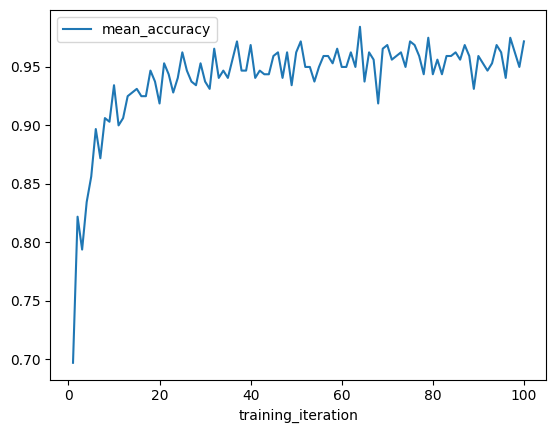

In [21]:
best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy")

Text(0, 0.5, 'Mean Test Accuracy')

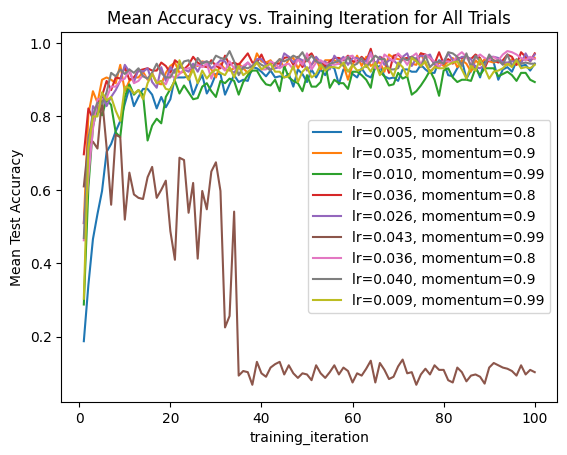

In [23]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "mean_accuracy", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "mean_accuracy", ax=ax, label=label)
ax.set_title("Mean Accuracy vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Accuracy")

## Accessing checkpoints and loading for test inference

In this case, we saved checkpoints as `TorchCheckpoint`, which are framework-specific checkpoints with methods to retrieve the model, given a model definition.

You may be performing custom checkpointing, creating checkpoints like `Checkpoint.from_dict({...})`. In this case, you can access the original `dict` format of the data by converting it via `best_result.checkpoint.to_dict()`.

In [25]:
from ray.train.torch import TorchCheckpoint
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders

# Pass in the model architecture
torch_checkpoint: TorchCheckpoint = best_result.checkpoint
new_model = torch_checkpoint.get_model(ConvNet())

Predicted Class = 5


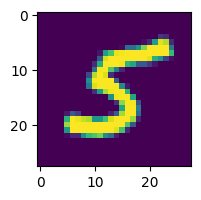

In [43]:
import matplotlib.pyplot as plt
import numpy as np

_, test_loader = get_data_loaders()
test_img = next(iter(test_loader))[0][0]
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

predicted_class = np.argmax(new_model(test_img).detach().numpy())
print("Predicted Class =", predicted_class)

Consider using [Ray AIR batch prediction](air-predictors) if you want to use a checkpointed model for large scale inference!

## Summary

In this guide, we looked at some common analysis workflows you can perform using the `ResultGrid` output returned by `Tuner.fit`. These included: **loading results from an experiment directory, exploring experiment-level and trial-level results, plotting logged metrics, and accessing trial checkpoints for inference.**

Take a look at [Tune's experiment tracking integrations](tune-experiment-tracking-examples) for more analysis tools that you can build into your Tune experiment with a few callbacks!